# Survival Analysis

- The first function draws the Survival Curve (Kaplan-Meier curve).
- The second function implements the logrank test, comparing two survival curves.

The formulas and the example are taken from Altman, Chapter 13

Author : Thomas Haslwanter, Date : Oct-2015

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from urllib.request import urlopen

In [2]:
def kaplanmeier(data):
    '''Determine and the Kaplan-Meier curve for the given data.
    Censored times are indicated with "1" in the second column, uncensored with "0"'''
    times = data[:,0]
    censored = data[:,1]
    atRisk = np.arange(len(times),0,-1)
    
    failures = times[censored==0]
    num_failures = len(failures)
    p = np.ones(num_failures+1)
    r = np.zeros(num_failures+1)
    se = np.zeros(num_failures+1)
    
    # Calculate the numbers-at-risk, the survival probability, and the standard error
    for ii in range(num_failures):
        if failures[ii] == failures[ii-1]:
            r[ii+1] = r[ii]
            p[ii+1] = p[ii]
            se[ii+1] = se[ii]
            
        else:
            r[ii+1] = np.max(atRisk[times==failures[ii]])
            p[ii+1] = p[ii] * (r[ii+1] - sum(failures==failures[ii]))/r[ii+1]
            se[ii+1] = p[ii+1]*np.sqrt((1-p[ii+1])/r[ii+1])
            # confidence intervals could be calculated as ci = p +/- 1.96 se
    
    # Plot survival curve (Kaplan-Meier curve)
    # Always start at t=0 and p=1, and make a line until the last measurement
    t = np.hstack((0, failures, np.max(times)))
    sp = np.hstack((p, p[-1]))
    
    return(p,atRisk,t,sp,se)

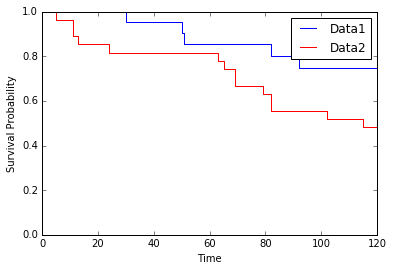

In [3]:
# Get the data
inFile1 = 'altman_13_2.txt'
inFile2 = 'altman_13_3.txt'
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/'
url1 = url_base + inFile1
url2 = url_base + inFile2
data_1 = np.genfromtxt(urlopen(url1), delimiter=',')
data_2 = np.genfromtxt(urlopen(url2), delimiter=',')

# Determine the Kaplan-Meier curves
(p1, r1, t1, sp1,se1) = kaplanmeier(data_1)
(p2, r2, t2, sp2,se2) = kaplanmeier(data_2)

# Make a combined plot for both datasets
plt.step(t1,sp1, where='post')
plt.hold(True)
plt.step(t2,sp2,'r', where='post')

plt.legend(['Data1', 'Data2'])
plt.ylim(0,1)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
#plt.show()

In [4]:
'''Logrank hypothesis test, comparing the survival times for two different datasets'''

times_1 = data_1[:,0]
censored_1 = data_1[:,1]
atRisk_1 = np.arange(len(times_1),0,-1)
failures_1 = times_1[censored_1==0]

times_2 = data_2[:,0]
censored_2 = data_2[:,1]
atRisk_2 = np.arange(len(times_2),0,-1)
failures_2 = times_2[censored_2==0]

failures = np.unique(np.hstack((times_1[censored_1==0], times_2[censored_2==0])))
num_failures = len(failures)
r1 = np.zeros(num_failures)
r2 = np.zeros(num_failures)
r  = np.zeros(num_failures)
f1 = np.zeros(num_failures)
f2 = np.zeros(num_failures)
f  = np.zeros(num_failures)
e1 = np.zeros(num_failures)
f1me1 = np.zeros(num_failures)
v = np.zeros(num_failures)

for ii in range(num_failures):
    r1[ii] = np.sum(times_1 >= failures[ii])
    r2[ii] = np.sum(times_2 >= failures[ii])
    r[ii] = r1[ii] + r2[ii]
    
    f1[ii] = np.sum(failures_1==failures[ii])
    f2[ii] = np.sum(failures_2==failures[ii])
    f[ii] = f1[ii] + f2[ii]
    
    e1[ii] = r1[ii]*f[ii]/r[ii]
    f1me1[ii] = f1[ii] - e1[ii]
    v[ii] = r1[ii]*r2[ii]*f[ii]*(r[ii]-f[ii]) / ( r[ii]**2 *(r[ii]-1) )

    O1 = np.sum(f1)
    O2 = np.sum(f2)
    E1 = np.sum(e1)
    O1mE1 = np.sum(f1me1)
    V = sum(v)
    
chi2 = (O1-E1)**2/V
p = stats.chi2.sf(chi2, 1)

print('X^2 = {0:5.3f}'.format(chi2))
if p < 0.05:
    print('p={0:6.4f}, the two survival curves are signifcantly different.'.format(p))
else:
    print('p={0:6.4f}, the two survival curves are not signifcantly different.'.format(p))

X^2 = 3.207
p=0.0733, the two survival curves are not signifcantly different.
